# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Activation, BatchNormalization

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [2]:
import pandas_ta as ta

In [3]:
path_to_file = "btc.csv"

In [4]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)
df = btc
df.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='date'>

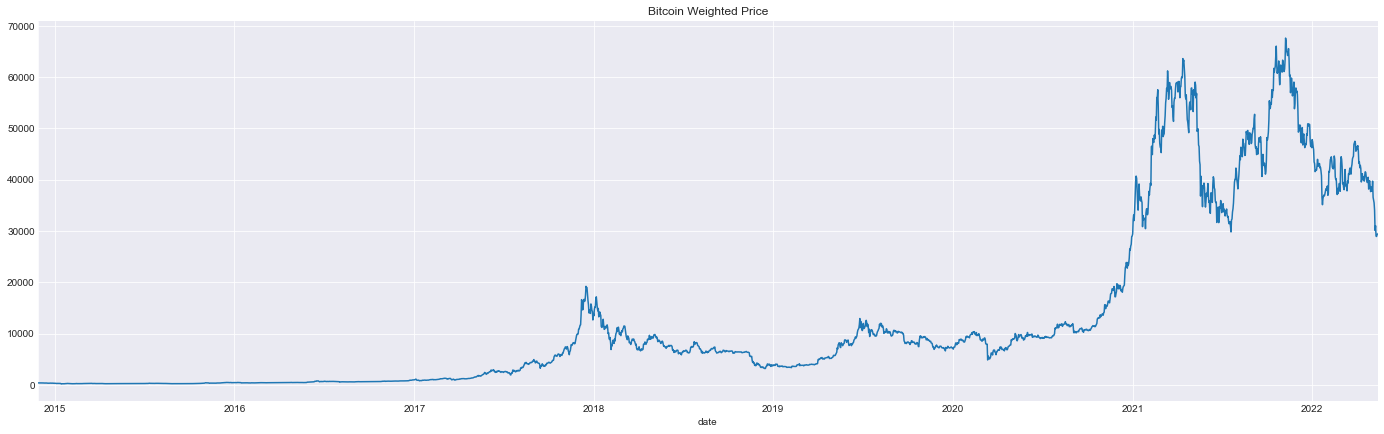

In [5]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc.close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [6]:
dff = (df.iloc[1:].reset_index(drop=True).copy()/df.iloc[:-1].reset_index(drop=True).copy())
dff_y = (df.iloc[1:].reset_index(drop=True).copy()/df.iloc[:-1].reset_index(drop=True).copy())

scaler = StandardScaler()

dff.open = scaler.fit_transform(dff.open.values.reshape(-1,1))

dff.high = scaler.fit_transform(dff.high.values.reshape(-1,1))

dff.low = scaler.fit_transform(dff.low.values.reshape(-1,1))

dff.close = scaler.fit_transform(dff.close.values.reshape(-1,1))

dff = dff.drop('Volume BTC',axis=1)



In [7]:
len_ = 90
def train_test_split(df):
    split_row = len(df) - int(0.04 * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def extract_windows_data(df):
    window_data = []
    for idx in range(len(df) - len_):
        tmp = df[idx: (idx + len_)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df,dff_y):
    train_data, test_data = train_test_split(df)
    train_data_, test_data_ = train_test_split(dff_y)
    X_train = extract_windows_data(train_data)
    X_test = extract_windows_data(test_data)
    y_train = train_data_['close'][len_:].values
    y_test = test_data_['close'][len_:].values
    y_train[y_train > 1] = 1
    y_train[y_train < 1] = 0
    y_test[y_test > 1] = 1
    y_test[y_test < 1] = 0
    return train_data, test_data, X_train, X_test, y_train, y_test


train, test, X_train, X_test, y_train, y_test = prepare_data(dff,dff_y)




print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train[:2])

X_train[0]

(2526, 90, 4)
(2526,)
(18, 90, 4)
(18,)
[1. 0.]


array([[ 8.26700412e-01,  3.34351871e-01,  7.26474654e-01,
        -3.09347904e-02],
       [-5.05742831e-02, -4.06774162e-01,  9.44305260e-03,
        -2.86427020e-01],
       [-7.19459590e-02, -3.90000848e-02, -7.92478615e-02,
         2.80376358e-01],
       [ 7.23459270e-02, -2.16835225e-02,  8.28796554e-02,
        -3.13603506e-03],
       [-3.44493313e-03, -5.26033568e-02, -1.25114057e-01,
        -2.31777013e-01],
       [-2.31653925e-01, -3.64859259e-01, -9.83377935e-01,
        -8.27537683e-01],
       [-8.26288987e-01, -1.46782339e-01,  2.08161475e-01,
         6.12193184e-01],
       [ 6.10721705e-01, -1.31774029e-01,  4.28118685e-01,
        -5.23309235e-02],
       [-5.25468746e-02, -2.41561220e-02,  6.06466185e-02,
         6.05086784e-02],
       [ 6.00795324e-02, -6.69578974e-02, -6.17588779e-01,
        -8.79939825e-01],
       [-8.78592122e-01, -9.77024220e-01, -1.43480969e+00,
        -1.03601354e+00],
       [-1.03437096e+00, -9.88820110e-01,  1.69838542e-01,
      

# train

In [8]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(units=128))
# model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 512)           1058816   
                                                                 
 dropout (Dropout)           (None, 90, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'my_best_model_.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [11]:
history = model.fit(X_train, y_train, epochs=5000, batch_size=128, shuffle=True,
                    validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/5000
20/20 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5428
Epoch 1: loss improved from inf to 0.69341, saving model to my_best_model_.hdf5
20/20 [==============================] - 65s 3s/step - loss: 0.6934 - accuracy: 0.5428 - val_loss: 0.7082 - val_accuracy: 0.3889
Epoch 2/5000
20/20 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5408
Epoch 2: loss improved from 0.69341 to 0.69037, saving model to my_best_model_.hdf5
20/20 [==============================] - 87s 4s/step - loss: 0.6904 - accuracy: 0.5408 - val_loss: 0.7030 - val_accuracy: 0.4444
Epoch 3/5000
20/20 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5368
Epoch 3: loss improved from 0.69037 to 0.68959, saving model to my_best_model_.hdf5
20/20 [==============================] - 85s 4s/step - loss: 0.6896 - accuracy: 0.5368 - val_loss: 0.7155 - val_accuracy: 0.4444
Epoch 4/5000
20/20 [==============================] - ETA: 0s - loss: 0.6911 

20/20 [==============================] - 86s 4s/step - loss: 0.6809 - accuracy: 0.5610 - val_loss: 0.6840 - val_accuracy: 0.6111
Epoch 30/5000
20/20 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.5523
Epoch 30: loss did not improve from 0.68089
20/20 [==============================] - 87s 4s/step - loss: 0.6825 - accuracy: 0.5523 - val_loss: 0.6792 - val_accuracy: 0.6111
Epoch 31/5000
20/20 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5570
Epoch 31: loss improved from 0.68089 to 0.67767, saving model to my_best_model_.hdf5
20/20 [==============================] - 86s 4s/step - loss: 0.6777 - accuracy: 0.5570 - val_loss: 0.6679 - val_accuracy: 0.6111
Epoch 32/5000
20/20 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.5610
Epoch 32: loss did not improve from 0.67767
20/20 [==============================] - 84s 4s/step - loss: 0.6789 - accuracy: 0.5610 - val_loss: 0.6667 - val_accuracy: 0.6111
Epoch 33/5000
20/20 

Epoch 57/5000
20/20 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.7332
Epoch 57: loss improved from 0.53251 to 0.50476, saving model to my_best_model_.hdf5
20/20 [==============================] - 86s 4s/step - loss: 0.5048 - accuracy: 0.7332 - val_loss: 0.9342 - val_accuracy: 0.4444
Epoch 58/5000
20/20 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.7359
Epoch 58: loss improved from 0.50476 to 0.49589, saving model to my_best_model_.hdf5
20/20 [==============================] - 89s 4s/step - loss: 0.4959 - accuracy: 0.7359 - val_loss: 1.0560 - val_accuracy: 0.4444
Epoch 59/5000
20/20 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.7454
Epoch 59: loss improved from 0.49589 to 0.47157, saving model to my_best_model_.hdf5
20/20 [==============================] - 86s 4s/step - loss: 0.4716 - accuracy: 0.7454 - val_loss: 1.1916 - val_accuracy: 0.4444
Epoch 60/5000
20/20 [==============================] - ETA: 0s - lo

20/20 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9576
Epoch 84: loss improved from 0.11959 to 0.10213, saving model to my_best_model_.hdf5
20/20 [==============================] - 87s 4s/step - loss: 0.1021 - accuracy: 0.9576 - val_loss: 3.1677 - val_accuracy: 0.4444
Epoch 85/5000
20/20 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9671
Epoch 85: loss improved from 0.10213 to 0.08218, saving model to my_best_model_.hdf5
20/20 [==============================] - 91s 5s/step - loss: 0.0822 - accuracy: 0.9671 - val_loss: 2.6917 - val_accuracy: 0.5556
Epoch 86/5000
20/20 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9774
Epoch 86: loss improved from 0.08218 to 0.05990, saving model to my_best_model_.hdf5
20/20 [==============================] - 86s 4s/step - loss: 0.0599 - accuracy: 0.9774 - val_loss: 3.4288 - val_accuracy: 0.5556
Epoch 87/5000
20/20 [==============================] - ETA: 0s - loss: 0.0595 - a

20/20 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9921
Epoch 112: loss did not improve from 0.00951
20/20 [==============================] - 83s 4s/step - loss: 0.0225 - accuracy: 0.9921 - val_loss: 5.5436 - val_accuracy: 0.5556
Epoch 113/5000
20/20 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9909
Epoch 113: loss did not improve from 0.00951
20/20 [==============================] - 82s 4s/step - loss: 0.0249 - accuracy: 0.9909 - val_loss: 4.8580 - val_accuracy: 0.5556
Epoch 114/5000
20/20 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9905
Epoch 114: loss did not improve from 0.00951
20/20 [==============================] - 82s 4s/step - loss: 0.0209 - accuracy: 0.9905 - val_loss: 4.7172 - val_accuracy: 0.5556
Epoch 115/5000
20/20 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9952
Epoch 115: loss did not improve from 0.00951
20/20 [==============================] - 83s 4s/step - l

Epoch 142/5000
20/20 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9921
Epoch 142: loss did not improve from 0.00489
20/20 [==============================] - 83s 4s/step - loss: 0.0235 - accuracy: 0.9921 - val_loss: 4.2330 - val_accuracy: 0.5556
Epoch 143/5000
20/20 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9964
Epoch 143: loss did not improve from 0.00489
20/20 [==============================] - 82s 4s/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 4.3750 - val_accuracy: 0.6667
Epoch 144/5000
20/20 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980
Epoch 144: loss did not improve from 0.00489
20/20 [==============================] - 83s 4s/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 4.8983 - val_accuracy: 0.5556
Epoch 145/5000
20/20 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9988
Epoch 145: loss improved from 0.00489 to 0.00397, saving model to my_best_model_.hdf5


20/20 [==============================] - 82s 4s/step - loss: 0.0137 - accuracy: 0.9952 - val_loss: 2.6157 - val_accuracy: 0.6667
Epoch 172/5000
20/20 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9996
Epoch 172: loss did not improve from 0.00049
20/20 [==============================] - 83s 4s/step - loss: 0.0049 - accuracy: 0.9996 - val_loss: 3.1773 - val_accuracy: 0.6111
Epoch 173/5000
20/20 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9992
Epoch 173: loss did not improve from 0.00049
20/20 [==============================] - 83s 4s/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 3.3234 - val_accuracy: 0.6111
Epoch 174/5000
20/20 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992
Epoch 174: loss did not improve from 0.00049
20/20 [==============================] - 82s 4s/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 3.5325 - val_accuracy: 0.6111
Epoch 175/5000
20/20 [==============================] -

20/20 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9952
Epoch 201: loss did not improve from 0.00040
20/20 [==============================] - 84s 4s/step - loss: 0.0189 - accuracy: 0.9952 - val_loss: 3.8736 - val_accuracy: 0.5556
Epoch 202/5000
20/20 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9984
Epoch 202: loss did not improve from 0.00040
20/20 [==============================] - 82s 4s/step - loss: 0.0076 - accuracy: 0.9984 - val_loss: 4.0569 - val_accuracy: 0.5000
Epoch 203/5000
20/20 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9964
Epoch 203: loss did not improve from 0.00040
20/20 [==============================] - 82s 4s/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 4.3928 - val_accuracy: 0.5000
Epoch 204/5000
20/20 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9984
Epoch 204: loss did not improve from 0.00040
20/20 [==============================] - 83s 4s/step - l

20/20 [==============================] - ETA: 0s - loss: 4.6960e-04 - accuracy: 1.0000
Epoch 231: loss did not improve from 0.00040
20/20 [==============================] - 39s 2s/step - loss: 4.6960e-04 - accuracy: 1.0000 - val_loss: 5.0685 - val_accuracy: 0.5556
Epoch 232/5000
20/20 [==============================] - ETA: 0s - loss: 5.7181e-04 - accuracy: 1.0000
Epoch 232: loss did not improve from 0.00040
20/20 [==============================] - 39s 2s/step - loss: 5.7181e-04 - accuracy: 1.0000 - val_loss: 5.1699 - val_accuracy: 0.5556
Epoch 233/5000
20/20 [==============================] - ETA: 0s - loss: 2.1936e-04 - accuracy: 1.0000
Epoch 233: loss improved from 0.00040 to 0.00022, saving model to my_best_model_.hdf5
20/20 [==============================] - 39s 2s/step - loss: 2.1936e-04 - accuracy: 1.0000 - val_loss: 5.3147 - val_accuracy: 0.5556
Epoch 234/5000
20/20 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9996
Epoch 234: loss did not improve from

Epoch 261/5000
20/20 [==============================] - ETA: 0s - loss: 4.0572e-04 - accuracy: 1.0000
Epoch 261: loss did not improve from 0.00022
20/20 [==============================] - 40s 2s/step - loss: 4.0572e-04 - accuracy: 1.0000 - val_loss: 4.8070 - val_accuracy: 0.5556
Epoch 262/5000
20/20 [==============================] - ETA: 0s - loss: 2.7517e-04 - accuracy: 1.0000
Epoch 262: loss did not improve from 0.00022
20/20 [==============================] - 40s 2s/step - loss: 2.7517e-04 - accuracy: 1.0000 - val_loss: 4.8442 - val_accuracy: 0.5556
Epoch 263/5000
20/20 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9988
Epoch 263: loss did not improve from 0.00022
20/20 [==============================] - 40s 2s/step - loss: 0.0023 - accuracy: 0.9988 - val_loss: 4.8866 - val_accuracy: 0.6111
Epoch 264/5000
20/20 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996
Epoch 264: loss did not improve from 0.00022
20/20 [==================

20/20 [==============================] - 40s 2s/step - loss: 8.6139e-05 - accuracy: 1.0000 - val_loss: 5.7582 - val_accuracy: 0.6111
Epoch 290/5000
20/20 [==============================] - ETA: 0s - loss: 7.2652e-05 - accuracy: 1.0000
Epoch 290: loss improved from 0.00008 to 0.00007, saving model to my_best_model_.hdf5
20/20 [==============================] - 40s 2s/step - loss: 7.2652e-05 - accuracy: 1.0000 - val_loss: 5.7719 - val_accuracy: 0.6111
Epoch 291/5000
20/20 [==============================] - ETA: 0s - loss: 4.7640e-05 - accuracy: 1.0000
Epoch 291: loss improved from 0.00007 to 0.00005, saving model to my_best_model_.hdf5
20/20 [==============================] - 40s 2s/step - loss: 4.7640e-05 - accuracy: 1.0000 - val_loss: 5.7819 - val_accuracy: 0.6111
Epoch 292/5000
20/20 [==============================] - ETA: 0s - loss: 7.6069e-05 - accuracy: 1.0000
Epoch 292: loss did not improve from 0.00005
20/20 [==============================] - 40s 2s/step - loss: 7.6069e-05 - accu

20/20 [==============================] - ETA: 0s - loss: 2.4148e-05 - accuracy: 1.0000
Epoch 318: loss did not improve from 0.00002
20/20 [==============================] - 40s 2s/step - loss: 2.4148e-05 - accuracy: 1.0000 - val_loss: 6.2674 - val_accuracy: 0.6111
Epoch 319/5000
20/20 [==============================] - ETA: 0s - loss: 1.8364e-05 - accuracy: 1.0000
Epoch 319: loss improved from 0.00002 to 0.00002, saving model to my_best_model_.hdf5
20/20 [==============================] - 40s 2s/step - loss: 1.8364e-05 - accuracy: 1.0000 - val_loss: 6.2925 - val_accuracy: 0.6111
Epoch 320/5000
20/20 [==============================] - ETA: 0s - loss: 2.0683e-05 - accuracy: 1.0000
Epoch 320: loss did not improve from 0.00002
20/20 [==============================] - 40s 2s/step - loss: 2.0683e-05 - accuracy: 1.0000 - val_loss: 6.3178 - val_accuracy: 0.6111
Epoch 321/5000
20/20 [==============================] - ETA: 0s - loss: 1.7073e-05 - accuracy: 1.0000
Epoch 321: loss improved from 0.

20/20 [==============================] - 40s 2s/step - loss: 9.9778e-06 - accuracy: 1.0000 - val_loss: 6.4480 - val_accuracy: 0.5556
Epoch 347/5000
20/20 [==============================] - ETA: 0s - loss: 8.6178e-06 - accuracy: 1.0000
Epoch 347: loss did not improve from 0.00001
20/20 [==============================] - 40s 2s/step - loss: 8.6178e-06 - accuracy: 1.0000 - val_loss: 6.4588 - val_accuracy: 0.5556
Epoch 348/5000
20/20 [==============================] - ETA: 0s - loss: 1.5314e-05 - accuracy: 1.0000
Epoch 348: loss did not improve from 0.00001
20/20 [==============================] - 40s 2s/step - loss: 1.5314e-05 - accuracy: 1.0000 - val_loss: 6.4558 - val_accuracy: 0.5556
Epoch 349/5000
20/20 [==============================] - ETA: 0s - loss: 8.0244e-06 - accuracy: 1.0000
Epoch 349: loss did not improve from 0.00001
20/20 [==============================] - 40s 2s/step - loss: 8.0244e-06 - accuracy: 1.0000 - val_loss: 6.4562 - val_accuracy: 0.5556
Epoch 350/5000
20/20 [=====

20/20 [==============================] - 41s 2s/step - loss: 9.5005e-06 - accuracy: 1.0000 - val_loss: 6.6784 - val_accuracy: 0.5556
Epoch 376/5000
20/20 [==============================] - ETA: 0s - loss: 7.9006e-06 - accuracy: 1.0000
Epoch 376: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 7.9006e-06 - accuracy: 1.0000 - val_loss: 6.6883 - val_accuracy: 0.5556
Epoch 377/5000
20/20 [==============================] - ETA: 0s - loss: 4.8582e-06 - accuracy: 1.0000
Epoch 377: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 4.8582e-06 - accuracy: 1.0000 - val_loss: 6.6948 - val_accuracy: 0.5556
Epoch 378/5000
20/20 [==============================] - ETA: 0s - loss: 1.0310e-05 - accuracy: 1.0000
Epoch 378: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 1.0310e-05 - accuracy: 1.0000 - val_loss: 6.7145 - val_accuracy: 0.5556
Epoch 379/5000
20/20 [=====

20/20 [==============================] - 40s 2s/step - loss: 3.0065e-06 - accuracy: 1.0000 - val_loss: 6.9038 - val_accuracy: 0.5556
Epoch 405/5000
20/20 [==============================] - ETA: 0s - loss: 1.0144e-05 - accuracy: 1.0000
Epoch 405: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 1.0144e-05 - accuracy: 1.0000 - val_loss: 6.9034 - val_accuracy: 0.5556
Epoch 406/5000
20/20 [==============================] - ETA: 0s - loss: 1.0451e-05 - accuracy: 1.0000
Epoch 406: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 1.0451e-05 - accuracy: 1.0000 - val_loss: 6.8683 - val_accuracy: 0.5556
Epoch 407/5000
20/20 [==============================] - ETA: 0s - loss: 1.0327e-05 - accuracy: 1.0000
Epoch 407: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 1.0327e-05 - accuracy: 1.0000 - val_loss: 6.8776 - val_accuracy: 0.5556
Epoch 408/5000
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9941
Epoch 434: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 3.9325 - val_accuracy: 0.5556
Epoch 435/5000
20/20 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9952
Epoch 435: loss did not improve from 0.00000
20/20 [==============================] - 40s 2s/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 3.4324 - val_accuracy: 0.5556
Epoch 436/5000
20/20 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9945
Epoch 436: loss did not improve from 0.00000
20/20 [==============================] - 41s 2s/step - loss: 0.0153 - accuracy: 0.9945 - val_loss: 4.0196 - val_accuracy: 0.5000
Epoch 437/5000
20/20 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9956
Epoch 437: loss did not improve from 0.00000
20/20 [==============================] - 41s 2s/step - l

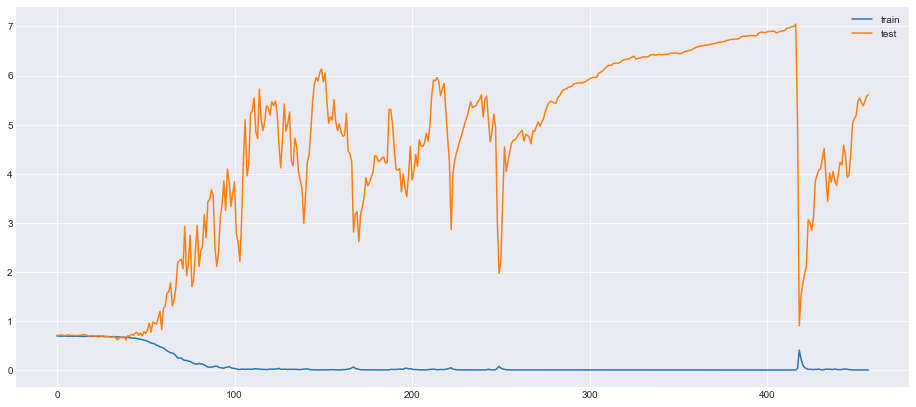

In [12]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model.hdf5')